In [59]:
import os
import numpy as np
import torch
import deepirtools
from deepirtools import IWAVE
from factor_analyzer import Rotator
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (9, 6)
deepirtools.manual_seed(123) # Seed for reproducibility.

# Comparing by gender

## Men

In [3]:
group = 1           # age class 'AK'
test_size = 0.2     # train-test split
sub = False         # subjective meassures
save_dir = './paper_models_test'

dat = pd.read_csv('../data/merged_male.csv')

y_0 = dat['LZ']
dat = dat.drop(['TalentID', 'AK', 'LZ'], axis=1).reset_index(drop=True)
X_0 = dat.iloc[:,:]

# # english variable-names
X_names = ['relative age', 'height', 'weight', 'sprint (20m)', 'agility','dribbling','ball control','juggling','tactical skills','kicking skills','endurance','psychological skills']
# X_0 = dat.iloc[:, 2:c]
# y_0 = dat.iloc[:, 16]
X_0.columns = X_names


#X, X_test, y, y_test = train_test_split(X_0, y_0, test_size=test_size, random_state=42, stratify=y_0)
#X.columns = X_names


# ___ SCALING
# MinMax [0,1]
#scaler_train = StandardScaler().fit(X)
#df_train = scaler_train.transform(X)
#y_train = np.asarray(y)
#df_test = scaler_train.transform(X_test)

# torch
#dft = torch.tensor(df_train)
#dftest = torch.tensor(df_test)
#sample_size = df_train.shape[0]
#test_size = df_test.shape[0]
#Y = dft.view(sample_size, -1)
#Ytest = dftest.view(test_size, -1)

# Full data
X_full = X_0.copy()
y_full = y_0.copy()

scaler = StandardScaler().fit(X_full)
df = scaler.transform(X_full)
y = np.asarray(y_full)

dft = torch.tensor(df)
sample_size = df.shape[0]
Y = dft.view(sample_size, -1)
n_items = Y.shape[1]

In [8]:
latent_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ref_idxs = Y.var(dim = 0).sort(descending = True)[1][:latent_size] # Find anchor items.
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)

model_name = 'iwave_male'
inf_net = [15,8]

# model
iwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3,
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = False,
              log_interval = 25,
              )

iwave.load_model(model_name, "../ni_wave_code/paper_models_test")


Initializing model parameters
Initialization ended in  0.0  seconds


In [9]:
# nIWAVE
model_name = 'niwave_male'
load_model = os.path.exists(save_dir + '/' + model_name + '.pth')

# specs
latent_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)
inf_net = [15,8]

#### Load second model
model_name = 'niwave_male'
inf_net = [15,8]

niwave = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3, # Bigger learning rate with increased
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = True,
              count_bins = 32,
              flow_length = 2,
              log_interval = 25,
              )

niwave.load_model(model_name, "../ni_wave_code/paper_models_test")


Initializing model parameters
Initialization ended in  36.51  seconds


#### Log-likelihood

In [10]:
#Xt_test = torch.tensor(df_test)
#test_size = Xt_test.shape[0]
#Y_test = Xt_test.view(test_size, -1)

ll = iwave.log_likelihood(data = Y, iw_samples = 5000)
nll = niwave.log_likelihood(data = Y, iw_samples = 5000) # Increasing iw_samples
print(-ll/sample_size,-nll/sample_size)


Computing approx. LL
Approx. LL computed in 33.68 seconds

Computing approx. LL
Approx. LL computed in 908.03 seconds
14.853278580264913 12.15816006429465


#### Rotation

##### IWAVE

In [21]:

loadings_iwave = np.asarray(iwave.loadings)

rotator = Rotator(method = "geomin_obl")
rot_loadings_iwave = torch.from_numpy(rotator.fit_transform(loadings_iwave))

rotator_ort = Rotator(method = "geomin_ort")
rot_loadings_iwave_ort = torch.from_numpy(rotator_ort.fit_transform(loadings_iwave))

##### nIWAVE

In [22]:
loadings_niwave = np.asarray(niwave.loadings)

rotator_niwave = Rotator(method = "geomin_obl")
rot_loadings_niwave = torch.from_numpy(rotator.fit_transform(loadings_niwave))

rotator_ort_niwave = Rotator(method = "geomin_ort")
rot_loadings_niwave_ort = torch.from_numpy(rotator_ort.fit_transform(loadings_niwave))

#### Scores

In [11]:
scores_iwave = iwave.scores(Y, mc_samples=50, iw_samples=50)
scores_iwave

tensor([[ 0.5607, -0.5567, -0.2079,  0.6857],
        [-0.1350, -1.2951, -0.7478, -0.1677],
        [-0.0682, -1.0112, -0.0814,  2.2279],
        ...,
        [ 0.7199,  0.7301,  0.2686, -0.3149],
        [-0.4584, -0.4198,  0.1344,  1.1934],
        [-0.4054,  0.1070,  0.1232,  0.2670]])

In [12]:
scores_niwave = niwave.scores(Y, mc_samples=50, iw_samples=50)
scores_niwave

tensor([[ 5.1066e-01,  3.8935e-02, -7.2868e-01,  4.8370e-01],
        [ 5.6216e-01, -5.1204e-01, -8.0240e-01,  1.0145e-01],
        [ 1.0410e+00,  1.6338e-01, -1.6961e+00,  1.4879e+00],
        ...,
        [-2.3030e-01,  3.8548e-01,  3.4691e-01, -4.7341e-01],
        [-9.6636e-02,  2.6953e-02,  1.6954e-01,  8.4196e-01],
        [-9.7594e-02,  1.5452e-04,  1.6836e-01,  6.1642e-02]])

In [13]:
# why this order of index?
final = pd.DataFrame(dat)
final['dim1_iwave'] = scores_iwave[:,3]
final['dim2_iwave'] = scores_iwave[:,0]
final['dim3_iwave'] = scores_iwave[:,2]
final['dim4_iwave'] = scores_iwave[:,1]
final['dim1_niwave'] = scores_niwave[:,3]
final['dim2_niwave'] = scores_niwave[:,0]
final['dim3_niwave'] = scores_niwave[:,1]
final['dim4_niwave'] = scores_niwave[:,2]
final['y'] = y

scaled_names = ['relative age scaled',
                'height scaled',
                'weight scaled',
                'sprint (20m) scaled',
                'agility scaled',
                'dribbling scaled',
                'ball control scaled',
                'juggling scaled',
                'tactical skills scaled',
                'kicking skills scaled',
                'endurance scaled',
                'psychological skills scaled']

final = pd.concat([final,pd.DataFrame(df, columns=scaled_names)],axis=1)
final

,relative_age,height,weight,SL20,GW,DR,BK,BJ,SKSC_TAK,SKSC_TEC,...,weight scaled,sprint (20m) scaled,agility scaled,dribbling scaled,ball control scaled,juggling scaled,tactical skills scaled,kicking skills scaled,endurance scaled,psychological skills scaled
0,62,175.0,50.000000,3.48,8.49,10.30,7.990000,6.0,2.000000,1.333333,...,1.119020,-0.370079,0.527551,-0.741615,-1.417041,0.488632,0.803709,-0.328371,0.278909,0.342178
1,207,170.0,51.000000,3.41,7.85,10.54,8.020000,23.0,1.000000,1.000000,...,1.233040,-0.723246,-1.034978,-0.423133,-1.394883,4.379016,-0.897609,-0.845168,-1.055583,-1.159984
2,162,168.0,63.000000,3.08,7.58,9.47,8.020000,9.0,2.857143,2.333333,...,2.601273,-2.388178,-1.694169,-1.843033,-1.394883,1.175170,2.261982,1.222020,0.278909,0.842898
3,14,180.0,67.000000,3.12,7.51,8.81,7.750000,15.0,1.285714,1.666667,...,3.057351,-2.186368,-1.865071,-2.718860,-1.594310,2.548247,-0.411518,0.188426,-1.055583,-1.159984
4,26,177.0,67.000000,3.25,7.80,9.48,8.110000,16.0,2.000000,1.666667,...,3.057351,-1.530486,-1.157050,-1.829763,-1.328407,2.777093,0.803709,0.188426,1.613402,0.342178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19172,20,143.0,35.540552,3.60,7.96,12.58,11.030000,6.0,2.714286,2.000000,...,-0.529638,0.235351,-0.766418,2.283967,0.828367,0.488632,2.018937,0.705223,0.278909,0.342178
19173,231,158.0,35.540552,3.68,8.79,11.34,10.820000,2.0,1.857143,1.666667,...,-0.529638,0.638971,1.259987,0.638475,0.673257,-0.426753,0.560664,0.188426,0.278909,0.342178
19174,161,155.0,35.540552,3.73,9.09,12.21,13.050000,3.0,1.714286,1.666667,...,-0.529638,0.891233,1.992422,1.792974,2.320382,-0.197907,0.317618,0.188426,0.278909,0.342178
19175,76,166.0,37.927997,3.40,7.50,9.41,8.800000,2.0,2.000000,2.000000,...,-0.257423,-0.773699,-1.889486,-1.922654,-0.818758,-0.426753,0.803709,0.705223,1.613402,0.342178


In [ ]:
final.to_csv(save_dir+'/data_scores', index=False)

In [14]:
succ = final[final['y']==1]
fail = final[final['y']==0]
succ_scores = succ.iloc[:,11:15]
fail_scores = fail.iloc[:,11:15]

succ_scores

,SKSC_PSY,dim1_iwave,dim2_iwave,dim3_iwave
0,2.000000,0.685708,0.560702,-0.207858
1,1.000000,-0.167689,-0.135021,-0.747761
3,1.000000,0.555753,-0.123452,-0.502874
4,2.000000,1.471326,0.267962,-0.402189
6,2.000000,0.419527,0.509412,-0.535523
...,...,...,...,...
19168,1.000000,-0.348219,0.500552,0.200133
19169,1.000000,-0.614301,-0.055908,0.296222
19173,2.000000,0.049402,0.468651,0.035039
19174,2.000000,-0.314891,0.719854,0.268610


In [15]:
from scipy.stats import ttest_ind
test_result = np.transpose(succ.iloc[:, 1:2].describe().iloc[[1,2], :])
temp_0 = np.transpose(fail.iloc[:, 1:2].describe().iloc[[1,2], :])
stat, p = ttest_ind(succ.iloc[:, 1],fail.iloc[:, 1])
test_result[['mean_0', 'std_0']] = temp_0
test_result["t-statistic"] = stat
test_result["p-value"] = p
for i in range(2, final.iloc[:, 1::].shape[1]):
    stat, p = ttest_ind(succ[final.columns[i]],fail[final.columns[i]])
    temp = np.transpose(succ.iloc[:, i:(i+1)].describe().iloc[[1,2], :])
    temp_0 = np.transpose(fail.iloc[:, i:(i+1)].describe().iloc[[1,2], :])
    temp[['mean_0', 'std_0']] = temp_0
    temp["t-statistic"] = stat
    temp["p-value"] = p
    test_result = pd.concat([test_result,temp],axis=0)
    # test_result = test_result.append(temp)
    # print('For ', name, 'the test statistic is %.3f and p=%.3f' % (stat, p))
test_result

C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,mean,std,mean_0,std_0,t-statistic,p-value
height,155.520085,10.037495,156.194618,10.359502,-4.574890,4.794552e-06
weight,40.010795,8.469214,40.350573,9.042937,-2.681663,7.332000e-03
SL20,3.585616,0.195301,3.522941,0.196125,22.162230,1.774262e-107
GW,8.338206,0.407230,8.213324,0.402555,21.349859,5.695341e-100
DR,10.999887,0.758583,10.725936,0.724176,25.584847,5.391455e-142
BK,10.092770,1.392074,9.734805,1.293172,18.460147,1.946831e-75
BJ,3.211018,3.836162,4.481038,4.737395,-20.329779,6.367751e-91
SKSC_TAK,1.202134,0.468447,1.834366,0.519989,-88.281943,0.000000e+00
SKSC_TEC,1.271968,0.576042,1.802607,0.599024,-62.460087,0.000000e+00
SKSC_KON,1.488447,0.691818,2.076175,0.687141,-59.001972,0.000000e+00


### PCA Comparision

In [16]:
from sklearn.decomposition import PCA
#pca_scree = PCA(n_components = 0.75, svd_solver='full')
pca_scree = PCA(svd_solver='full')
pca_scree.fit(df)
reduced = pca_scree.transform(df)
pca_scree.explained_variance_

array([3.49466493, 2.37824853, 1.32085736, 1.00431766, 0.9374688 ,
       0.6512617 , 0.55669771, 0.49793773, 0.36927415, 0.33376055,
       0.2358596 , 0.22027705])

Text(0.5, 1.0, 'Scree Plot')

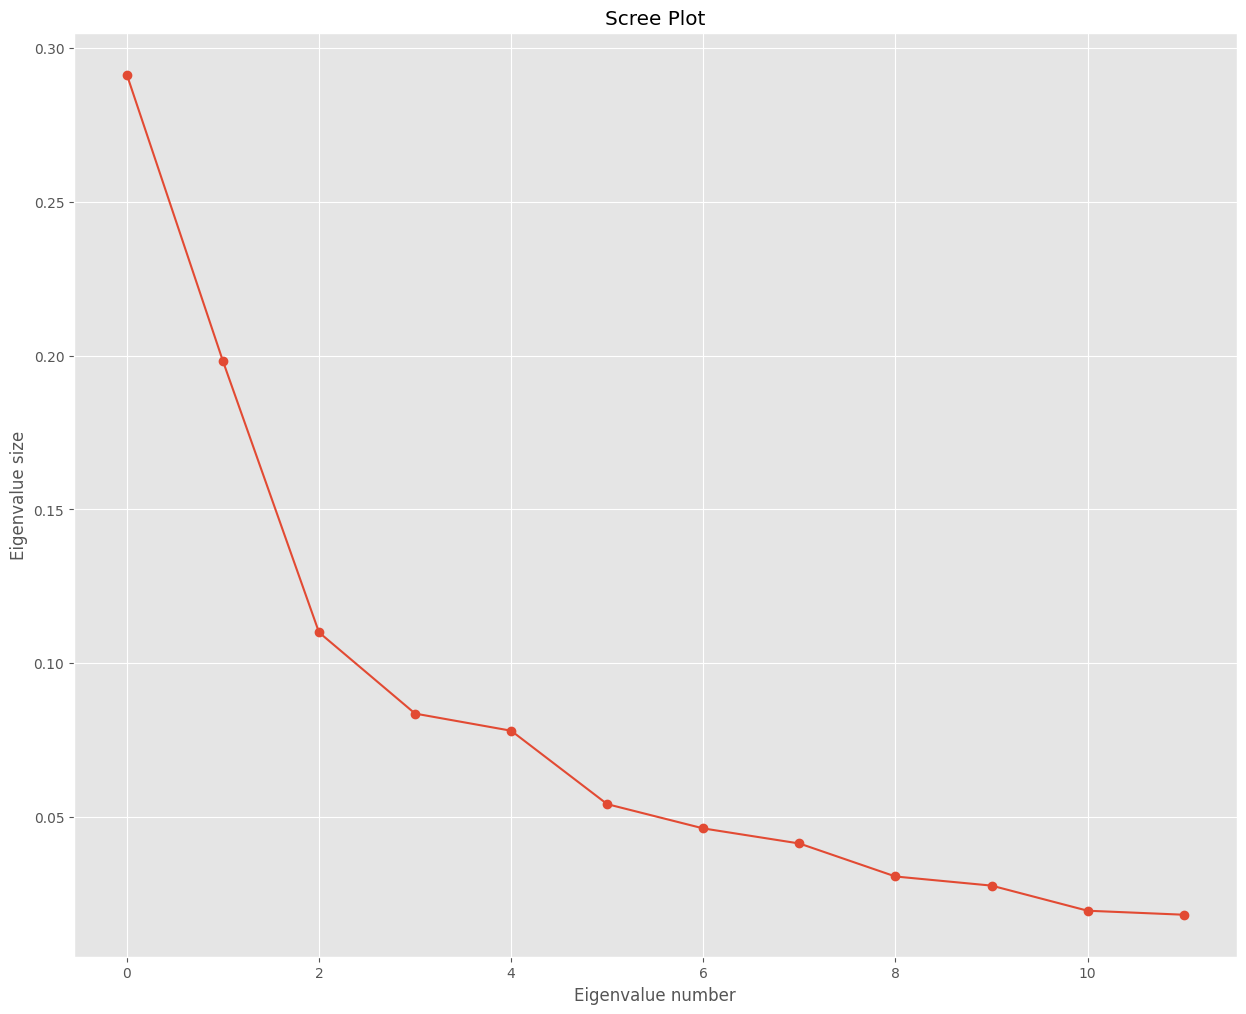

In [17]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(pca_scree.explained_variance_ratio_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [18]:
pca = PCA(n_components = 4, svd_solver='full',)
pca.fit(df)
reduced = pca.transform(df)
loadings = pd.DataFrame(pca.components_.T)

[Text(0.5, 1.0, 'Loadings oblique_spl')]

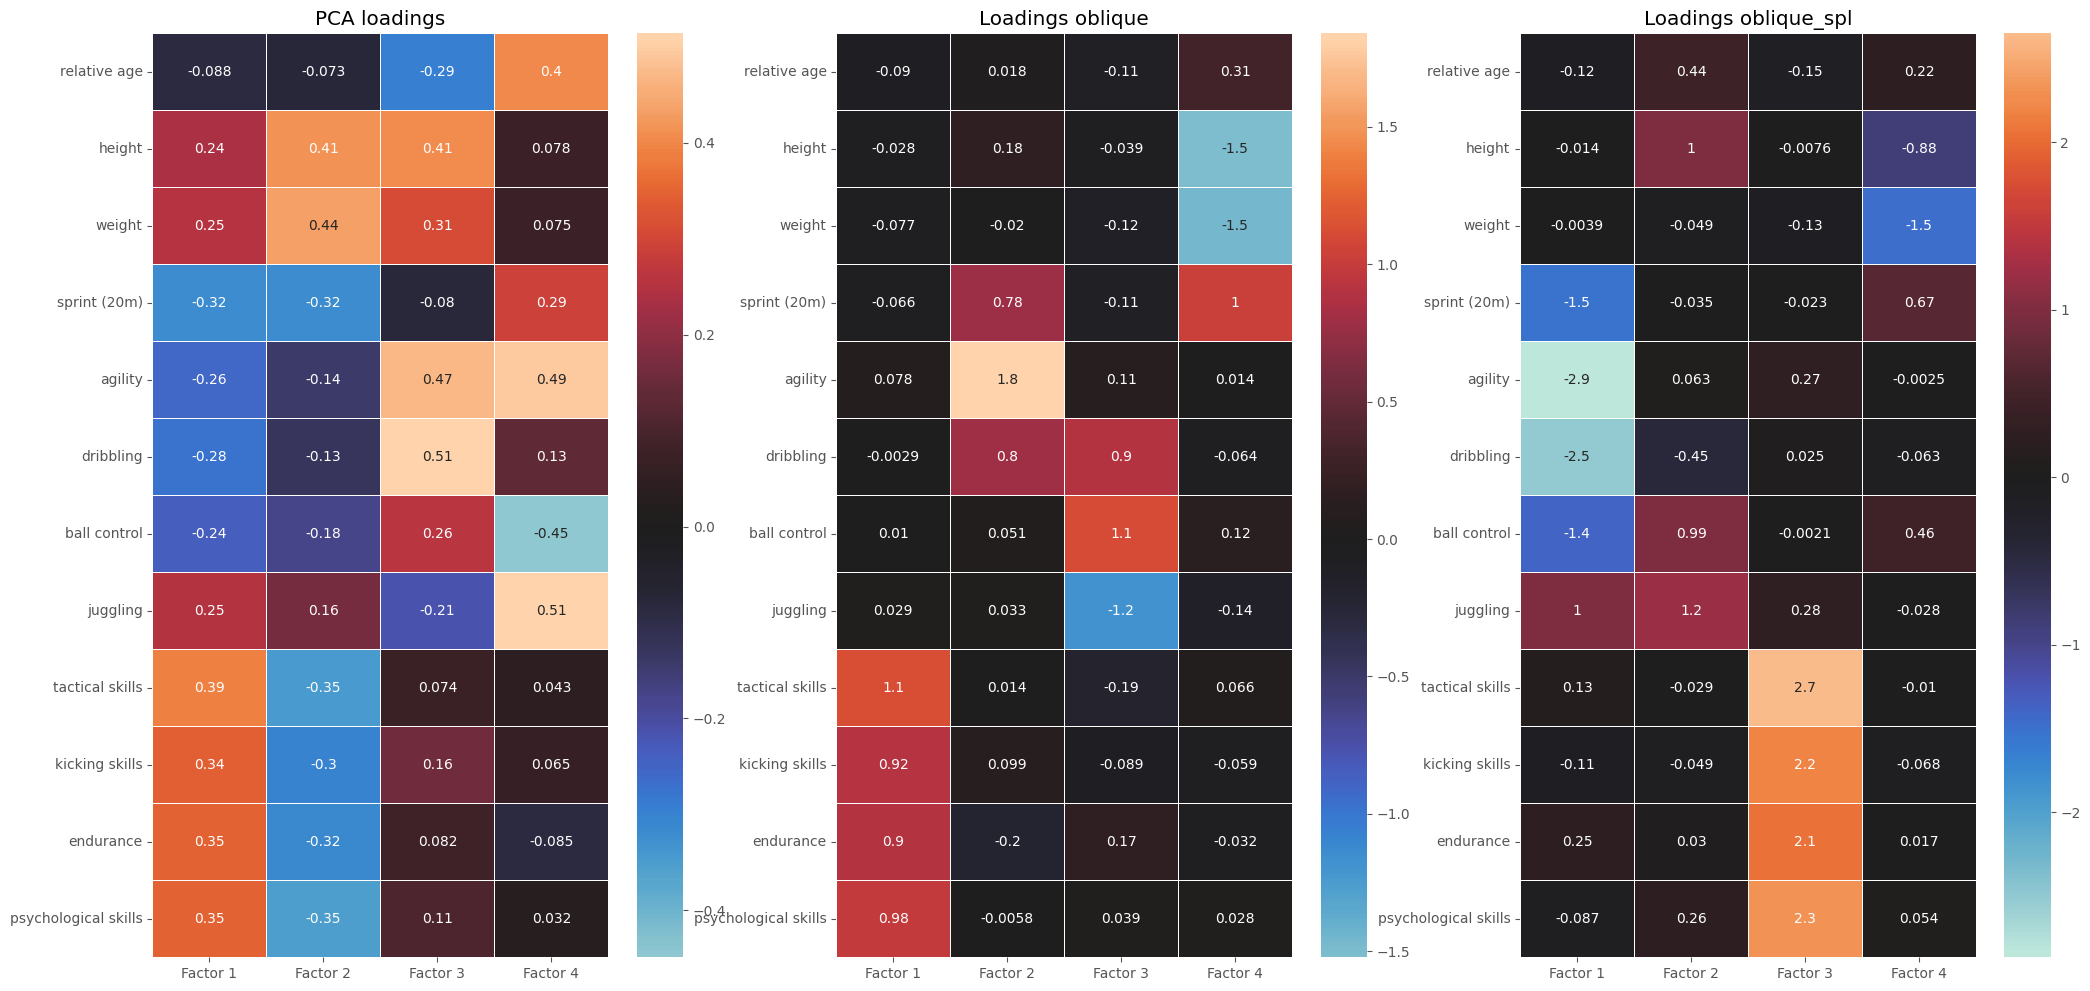

In [23]:
fig, axs = plt.subplots(1,3, figsize=(25,12))
sns.heatmap(ax=axs[0], data=loadings, annot=True, linewidths=0.5, vmin=loadings.min().min(), vmax=loadings.max().max(), center=0,xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='PCA loadings')
sns.heatmap(ax=axs[1], data=rot_loadings_iwave[:,[3,0,2,1]], annot=True, linewidths=0.5, vmin=rot_loadings_iwave.min(), vmax=rot_loadings_iwave.max(), center=0, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='Loadings oblique')
sns.heatmap(ax=axs[2], data=rot_loadings_niwave[:,[3,0,1,2,]], annot=True, linewidths=0.5, vmin=rot_loadings_niwave.min(), vmax=rot_loadings_niwave.max(), center=0, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='Loadings oblique_spl')

[Text(0.5, 1.0, 'Nonlinear loadings')]

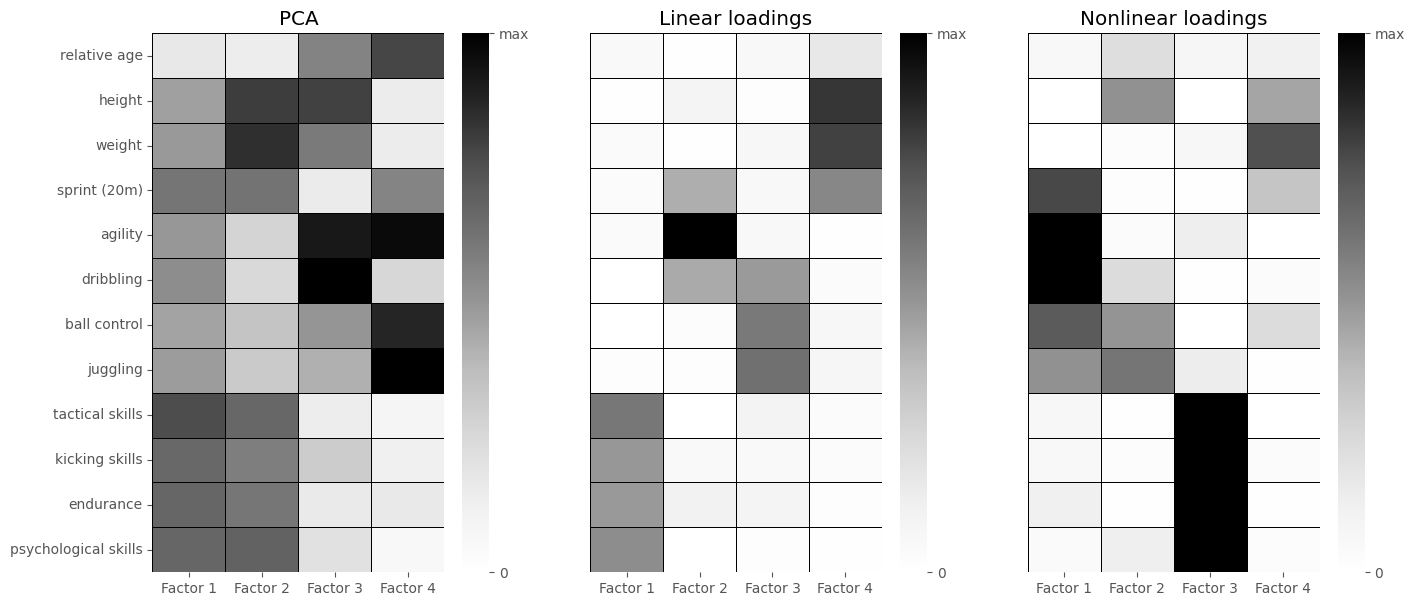

In [24]:
fig, axs = plt.subplots(1,3, figsize=(16,7), frameon=True)
sns.heatmap(ax=axs[0], data=abs(loadings), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=loadings.max().max()/2, vmax=loadings.max().max(),xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,loadings.max().max()],}).set(title='PCA')
sns.heatmap(ax=axs[1], data=abs(rot_loadings_iwave[:,[3,0,2,1]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=rot_loadings_iwave.max()/2, vmax=rot_loadings_iwave.max(), xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_iwave.max()],}).set(title='Linear loadings')
sns.heatmap(ax=axs[2], data=abs(rot_loadings_niwave[:,[3,0,1,2,]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=(rot_loadings_niwave.max()-0.7)/2,vmax=rot_loadings_niwave.max()-0.7, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_niwave.max()-0.7],}).set(title='Nonlinear loadings')

In [46]:
rot_load_table = torch.clone(rot_loadings_iwave)
rot_load_table_spl = torch.clone(rot_loadings_niwave)

loadings_table = loadings.copy()
loadings_table['variable'] = X_names
loadings_table.set_index('variable', inplace=True)
loadings_table.columns = ['fact. 1', 'fact. 2', 'fact. 3', 'fact. 4']

loadings_table[['iwave fact. 1', 'iwave fact. 2', 'iwave fact. 3', 'iwave fact. 4']] = rot_loadings_iwave[:,[3,0,2,1]]
loadings_table[['niwave fact. 1', 'niwave fact. 2', 'niwave fact. 3', 'niwave fact. 4']] = rot_loadings_niwave[:,[3,0,1,2,]]

loadings_table = round(loadings_table,2)
cut_percent = 0.1
pca_cut = cut_percent*loadings.max().max()
iwave_cut = np.asarray(cut_percent*rot_loadings_iwave.max())
niwave_cut = np.asarray(cut_percent*(rot_loadings_niwave.max()-0.7))
# pca
loadings_table.loc[np.abs(loadings_table['fact. 1']) < pca_cut, 'fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 2']) < pca_cut, 'fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 3']) < pca_cut, 'fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 4']) < pca_cut, 'fact. 4'] = '.'
# iwave
loadings_table.loc[np.abs(loadings_table['iwave fact. 1']) < iwave_cut, 'iwave fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 2']) < iwave_cut, 'iwave fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 3']) < iwave_cut, 'iwave fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 4']) < iwave_cut, 'iwave fact. 4'] = '.'
# niwave
loadings_table.loc[np.abs(loadings_table['niwave fact. 1']) < niwave_cut, 'niwave fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 2']) < niwave_cut, 'niwave fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 3']) < niwave_cut, 'niwave fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 4']) < niwave_cut, 'niwave fact. 4'] = '.'


# print(round(loadings_table,2).to_latex(escape=True, index=True, index_names=False, column_format='lrrrrrrrrrrrr', ))
round(loadings_table,2)

C:\Users\eduar\AppData\Local\Temp\ipykernel_9644\1847926413.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  loadings_table.loc[np.abs(loadings_table['fact. 1']) < pca_cut, 'fact. 1'] = '.'
C:\Users\eduar\AppData\Local\Temp\ipykernel_9644\1847926413.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  loadings_table.loc[np.abs(loadings_table['fact. 2']) < pca_cut, 'fact. 2'] = '.'
C:\Users\eduar\AppData\Local\Temp\ipykernel_9644\1847926413.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast

,fact. 1,fact. 2,fact. 3,fact. 4,iwave fact. 1,iwave fact. 2,iwave fact. 3,iwave fact. 4,niwave fact. 1,niwave fact. 2,niwave fact. 3,niwave fact. 4
variable,,,,,,,,,,,,
relative age,.,-0.13,-0.21,0.62,.,.,.,0.31,.,0.44,.,0.22
height,0.18,0.47,0.41,.,.,.,.,-1.52,.,1.01,.,-0.88
weight,0.21,0.46,0.33,0.11,.,.,.,-1.46,.,.,.,-1.47
sprint (20m),-0.25,-0.31,0.16,0.42,.,0.78,.,1.02,-1.51,.,.,0.67
agility,-0.24,-0.08,0.59,0.36,.,1.84,.,.,-2.87,.,0.27,.
dribbling,-0.29,-0.13,0.42,-0.16,.,0.8,0.9,.,-2.5,-0.45,.,.
ball control,-0.27,-0.22,0.18,-0.31,.,.,1.11,.,-1.4,0.99,.,0.46
juggling,0.27,0.2,-0.07,0.4,.,.,-1.17,.,1.01,1.21,0.28,.
tactical skills,0.42,-0.28,0.12,.,1.12,.,-0.19,.,.,.,2.65,.


## Women

In [27]:
group = 1           # age class 'AK'
test_size = 0.2     # train-test split
sub = False         # subjective meassures
save_dir = './paper_models_test'

dat = pd.read_csv('../data/merged_female.csv')

y_0 = dat['LZ']
dat = dat.drop(['TalentID', 'AK', 'LZ'], axis=1).reset_index(drop=True)
X_0 = dat.iloc[:,:]

# # english variable-names
X_names = ['relative age', 'height', 'weight', 'sprint (20m)', 'agility','dribbling','ball control','juggling','tactical skills','kicking skills','endurance','psychological skills']
X_0.columns = X_names


#X, X_test, y, y_test = train_test_split(X_0, y_0, test_size=test_size, random_state=42, stratify=y_0)
#X.columns = X_names


# ___ SCALING
# MinMax [0,1]
#scaler_train = StandardScaler().fit(X)
#df_train = scaler_train.transform(X)
#y_train = np.asarray(y)
#df_test = scaler_train.transform(X_test)

# torch
#dft = torch.tensor(df_train)
#dftest = torch.tensor(df_test)
#sample_size = df_train.shape[0]
#test_size = df_test.shape[0]
#Y = dft.view(sample_size, -1)
#Ytest = dftest.view(test_size, -1)

# Full data
X_full = X_0.copy()
y_full = y_0.copy()

scaler = StandardScaler().fit(X_full)
df_fem = scaler.transform(X_full)
y = np.asarray(y_full)

dft_fem = torch.tensor(df_fem)
sample_size = df.shape[0]
Y_fem = dft_fem.view(sample_size, -1)
n_items = Y_fem.shape[1]

### Bartlet test

In [47]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_fem)
chi_square_value, p_value

(6080.164131613169, 0.0)

In [29]:
latent_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ref_idxs = Y.var(dim = 0).sort(descending = True)[1][:latent_size] # Find anchor items.
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)

model_name = 'iwave_female'
inf_net = [15,8]

# model
iwave_fem = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3,
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = False,
              log_interval = 25,
              )

iwave_fem.load_model(model_name, "../ni_wave_code/paper_models_test")


Initializing model parameters
Initialization ended in  0.0  seconds


In [30]:
# nIWAVE
model_name = 'niwave_female'
load_model = os.path.exists(save_dir + '/' + model_name + '.pth')

# specs
latent_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_idxs = [1,3,6,8]
A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1 # Fix anchor item's loading on one factor to one.
A = A.diag()
ints_mask = torch.zeros(n_items)
inf_net = [15,8]

#### Load second model
model_name = 'niwave_female'
inf_net = [15,8]

niwave_fem = IWAVE(model_type = "normal",
              learning_rate = 5e-4 if device=="cpu" else 1e-3, # Bigger learning rate with increased
              gradient_estimator='dreg',
              n_intervals = 100,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = inf_net,
              latent_size = latent_size,
              n_items = n_items,
              fixed_variances = False,
              fixed_means = False,
              use_spline_prior = True,
              count_bins = 32,
              flow_length = 2,
              log_interval = 25,
              )

niwave_fem.load_model(model_name, "../ni_wave_code/paper_models_test")


Initializing model parameters
Initialization ended in  40.53  seconds


#### Log-likelihood

In [49]:
#Xt_test = torch.tensor(df_test)
#test_size = Xt_test.shape[0]
#Y_test = Xt_test.view(test_size, -1)

ll = iwave_fem.log_likelihood(data = Y_fem, iw_samples = 5000)
nll = niwave_fem.log_likelihood(data = Y_fem, iw_samples = 5000) # Increasing iw_samples
print(-ll/sample_size,-nll/sample_size)


Computing approx. LL
Approx. LL computed in 2.09 seconds

Computing approx. LL
Approx. LL computed in 38.68 seconds
15.065820160611596 13.181297397176346


#### Rotation

##### IWAVE

In [50]:

loadings_iwave_fem = np.asarray(iwave_fem.loadings)

rotator = Rotator(method = "geomin_obl")
rot_loadings_iwave_fem = torch.from_numpy(rotator.fit_transform(loadings_iwave_fem))

rotator_ort = Rotator(method = "geomin_ort")
rot_loadings_iwave_fem_ort = torch.from_numpy(rotator_ort.fit_transform(loadings_iwave_fem))

##### nIWAVE

In [51]:
loadings_niwave_fem = np.asarray(niwave_fem.loadings)

rotator_niwave_fem = Rotator(method = "geomin_obl")
rot_loadings_niwave_fem = torch.from_numpy(rotator.fit_transform(loadings_niwave_fem))

rotator_ort_niwave_fem = Rotator(method = "geomin_ort")
rot_loadings_niwave_fem_ort = torch.from_numpy(rotator_ort.fit_transform(loadings_niwave_fem))

#### Scores

In [52]:
scores_iwave_fem = iwave_fem.scores(Y_fem, mc_samples=50, iw_samples=50)
scores_iwave_fem

tensor([[-0.2057, -0.4992, -0.0825, -0.0062],
        [ 0.6115, -0.4270,  0.4523,  0.7136],
        [-0.1576,  0.1388, -0.4326,  1.6018],
        ...,
        [ 0.0805,  0.3824,  0.0083,  0.3694],
        [-0.1997,  0.8343, -0.0739,  0.6942],
        [-0.2354,  0.3858, -0.1525, -0.1745]])

In [53]:
scores_niwave_fem = niwave_fem.scores(Y_fem, mc_samples=50, iw_samples=50)
scores_niwave_fem

tensor([[ 0.2178,  0.4482, -0.3311, -0.7008],
        [ 0.2571,  0.5980, -0.6064,  0.1971],
        [ 0.4873,  0.9088,  0.0232,  0.6611],
        ...,
        [ 0.2103,  0.8935,  0.2069, -0.0708],
        [ 0.2751,  0.9374,  0.2075,  0.3230],
        [ 0.2120,  0.7422,  0.2079, -0.6013]])

In [54]:
# why this order of index?
final = pd.DataFrame(dat)
final['dim1_iwave'] = scores_iwave_fem[:,3]
final['dim2_iwave'] = scores_iwave_fem[:,0]
final['dim3_iwave'] = scores_iwave_fem[:,2]
final['dim4_iwave'] = scores_iwave_fem[:,1]
final['dim1_niwave'] = scores_niwave_fem[:,3]
final['dim2_niwave'] = scores_niwave_fem[:,0]
final['dim3_niwave'] = scores_niwave_fem[:,1]
final['dim4_niwave'] = scores_niwave_fem[:,2]
final['y'] = y

scaled_names = ['relative age scaled',
                'height scaled',
                'weight scaled',
                'sprint (20m) scaled',
                'agility scaled',
                'dribbling scaled',
                'ball control scaled',
                'juggling scaled',
                'tactical skills scaled',
                'kicking skills scaled',
                'endurance scaled',
                'psychological skills scaled']

final = pd.concat([final,pd.DataFrame(df, columns=scaled_names)],axis=1)
final

,relative_age,height,weight,SL20,GW,DR,BK,BJ,SKSC_TAK,SKSC_TEC,...,weight scaled,sprint (20m) scaled,agility scaled,dribbling scaled,ball control scaled,juggling scaled,tactical skills scaled,kicking skills scaled,endurance scaled,psychological skills scaled
0,87,153.000000,49.000000,3.43,8.04,11.70,9.89,5.0,1.571429,1.333333,...,1.047908,-0.997444,-0.919039,0.266900,-0.485701,0.435031,0.065882,-0.134025,-1.125506,-0.875553
1,228,176.000000,56.000000,3.74,8.28,11.67,12.18,1.0,2.000000,2.000000,...,1.917912,0.761076,-0.314910,0.234630,0.949766,-0.519849,0.758095,0.889257,1.572528,0.116632
2,247,154.000000,40.000000,3.66,8.09,10.34,9.24,18.0,2.571429,2.000000,...,-0.070667,0.307264,-0.793178,-1.195988,-0.893148,3.538392,1.681046,0.889257,1.572528,1.604910
3,162,172.000000,60.000000,3.54,9.20,11.50,7.96,13.0,2.571429,2.333333,...,2.415057,-0.373453,2.000919,0.051769,-1.695505,2.344792,1.681046,1.400898,1.572528,1.108817
4,109,164.429577,53.556338,3.66,8.26,11.32,8.11,7.0,2.714286,2.333333,...,1.614198,0.307264,-0.365254,-0.141848,-1.601479,0.912471,1.911783,1.400898,1.572528,1.604910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,17,151.000000,35.276000,3.68,8.49,11.86,10.60,1.0,1.714286,2.000000,...,-0.657795,0.420717,0.213703,0.439004,-0.040644,-0.519849,0.296620,0.889257,0.223511,0.612725
1523,172,165.000000,38.294286,3.89,8.81,11.11,11.44,1.0,1.285714,1.666667,...,-0.282664,1.611973,1.019209,-0.367735,0.485903,-0.519849,-0.395593,0.377616,-1.125506,-0.379460
1524,42,154.000000,35.276000,3.68,8.57,11.42,10.48,2.0,1.857143,1.666667,...,-0.657795,0.420717,0.415080,-0.034283,-0.115865,-0.281129,0.527357,0.377616,0.223511,1.108817
1525,180,139.000000,35.276000,3.63,8.52,10.67,13.00,1.0,2.428571,1.666667,...,-0.657795,0.137085,0.289220,-0.841022,1.463775,-0.519849,1.450308,0.377616,0.223511,1.108817


In [ ]:
final.to_csv(save_dir+'/data_scores_fem', index=False)

In [56]:
succ = final[final['y']==1]
fail = final[final['y']==0]
succ_scores = succ.iloc[:,12:16]
fail_scores = fail.iloc[:,12:16]

succ_scores

,dim1_iwave,dim2_iwave,dim3_iwave,dim4_iwave
0,-0.006231,-0.205652,-0.082540,-0.499230
1,0.713586,0.611506,0.452285,-0.427003
14,-0.979413,0.185346,-0.198083,-0.832940
30,0.318268,0.402200,0.091812,-0.163139
38,-0.315037,0.492174,-0.151248,-0.487515
...,...,...,...,...
1515,0.377688,-0.442913,0.274325,-0.661920
1520,-0.324788,-0.315980,-0.077711,0.139475
1522,0.188507,-0.037775,0.039942,0.442187
1523,-0.531060,0.468038,-0.110559,0.105250


In [57]:
from scipy.stats import ttest_ind
test_result = np.transpose(succ.iloc[:, 1:2].describe().iloc[[1,2], :])
temp_0 = np.transpose(fail.iloc[:, 1:2].describe().iloc[[1,2], :])
stat, p = ttest_ind(succ.iloc[:, 1],fail.iloc[:, 1])
test_result[['mean_0', 'std_0']] = temp_0
test_result["t-statistic"] = stat
test_result["p-value"] = p
for i in range(2, final.iloc[:, 1::].shape[1]):
    stat, p = ttest_ind(succ[final.columns[i]],fail[final.columns[i]])
    temp = np.transpose(succ.iloc[:, i:(i+1)].describe().iloc[[1,2], :])
    temp_0 = np.transpose(fail.iloc[:, i:(i+1)].describe().iloc[[1,2], :])
    temp[['mean_0', 'std_0']] = temp_0
    temp["t-statistic"] = stat
    temp["p-value"] = p
    test_result = pd.concat([test_result,temp],axis=0)
    # test_result = test_result.append(temp)
    # print('For ', name, 'the test statistic is %.3f and p=%.3f' % (stat, p))
test_result

C:\Users\eduar\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,mean,std,mean_0,std_0,t-statistic,p-value
height,155.246334,8.842227,156.284977,8.535486,-2.323926,2.026033e-02
weight,39.565062,7.559946,41.361522,8.333911,-4.356386,1.410556e-05
SL20,3.639345,0.173217,3.579355,0.174372,6.694987,3.022446e-11
GW,8.483316,0.396242,8.343302,0.387517,6.941349,5.725645e-12
DR,11.746186,0.970392,11.219319,0.826150,11.452195,3.442324e-29
BK,11.144129,1.682528,10.286127,1.414139,10.822157,2.383450e-26
BJ,1.993256,2.637629,4.113503,4.895718,-10.140150,1.989426e-23
SKSC_TAK,1.176982,0.496479,1.810082,0.561415,-23.016192,7.397482e-101
SKSC_TEC,1.166667,0.585232,1.621336,0.631530,-14.426574,2.533334e-44
SKSC_KON,1.528190,0.695949,2.076202,0.685229,-15.411256,6.488904e-50


### PCA Comparision

In [58]:
from sklearn.decomposition import PCA
#pca_scree = PCA(n_components = 0.75, svd_solver='full')
pca_scree = PCA(svd_solver='full')
pca_scree.fit(df_fem)
reduced = pca_scree.transform(df_fem)
pca_scree.explained_variance_

array([3.67681827, 2.05158559, 1.25957476, 1.00216254, 0.95678461,
       0.64915489, 0.59964523, 0.499345  , 0.41492557, 0.35514571,
       0.32317659, 0.21954492])

Text(0.5, 1.0, 'Scree Plot')

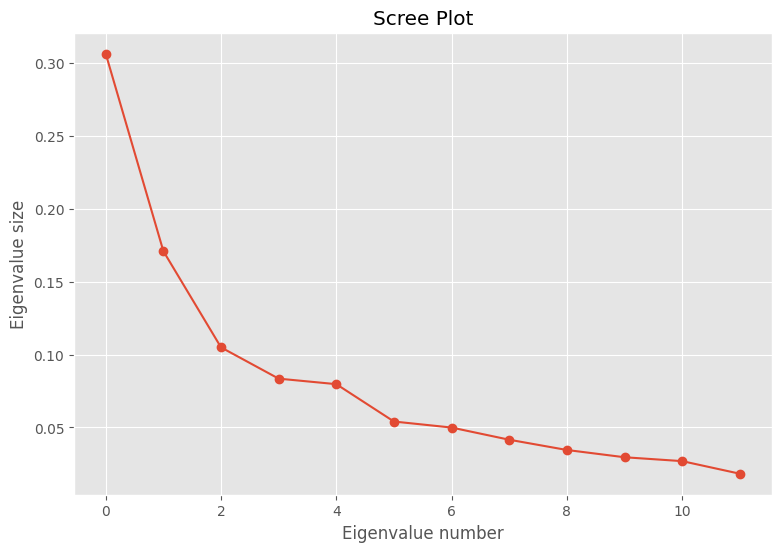

In [60]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(pca_scree.explained_variance_ratio_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [61]:
pca = PCA(n_components = 4, svd_solver='full',)
pca.fit(df_fem)
reduced = pca.transform(df_fem)
loadings = pd.DataFrame(pca.components_.T)

[Text(0.5, 1.0, 'Loadings oblique_spl')]

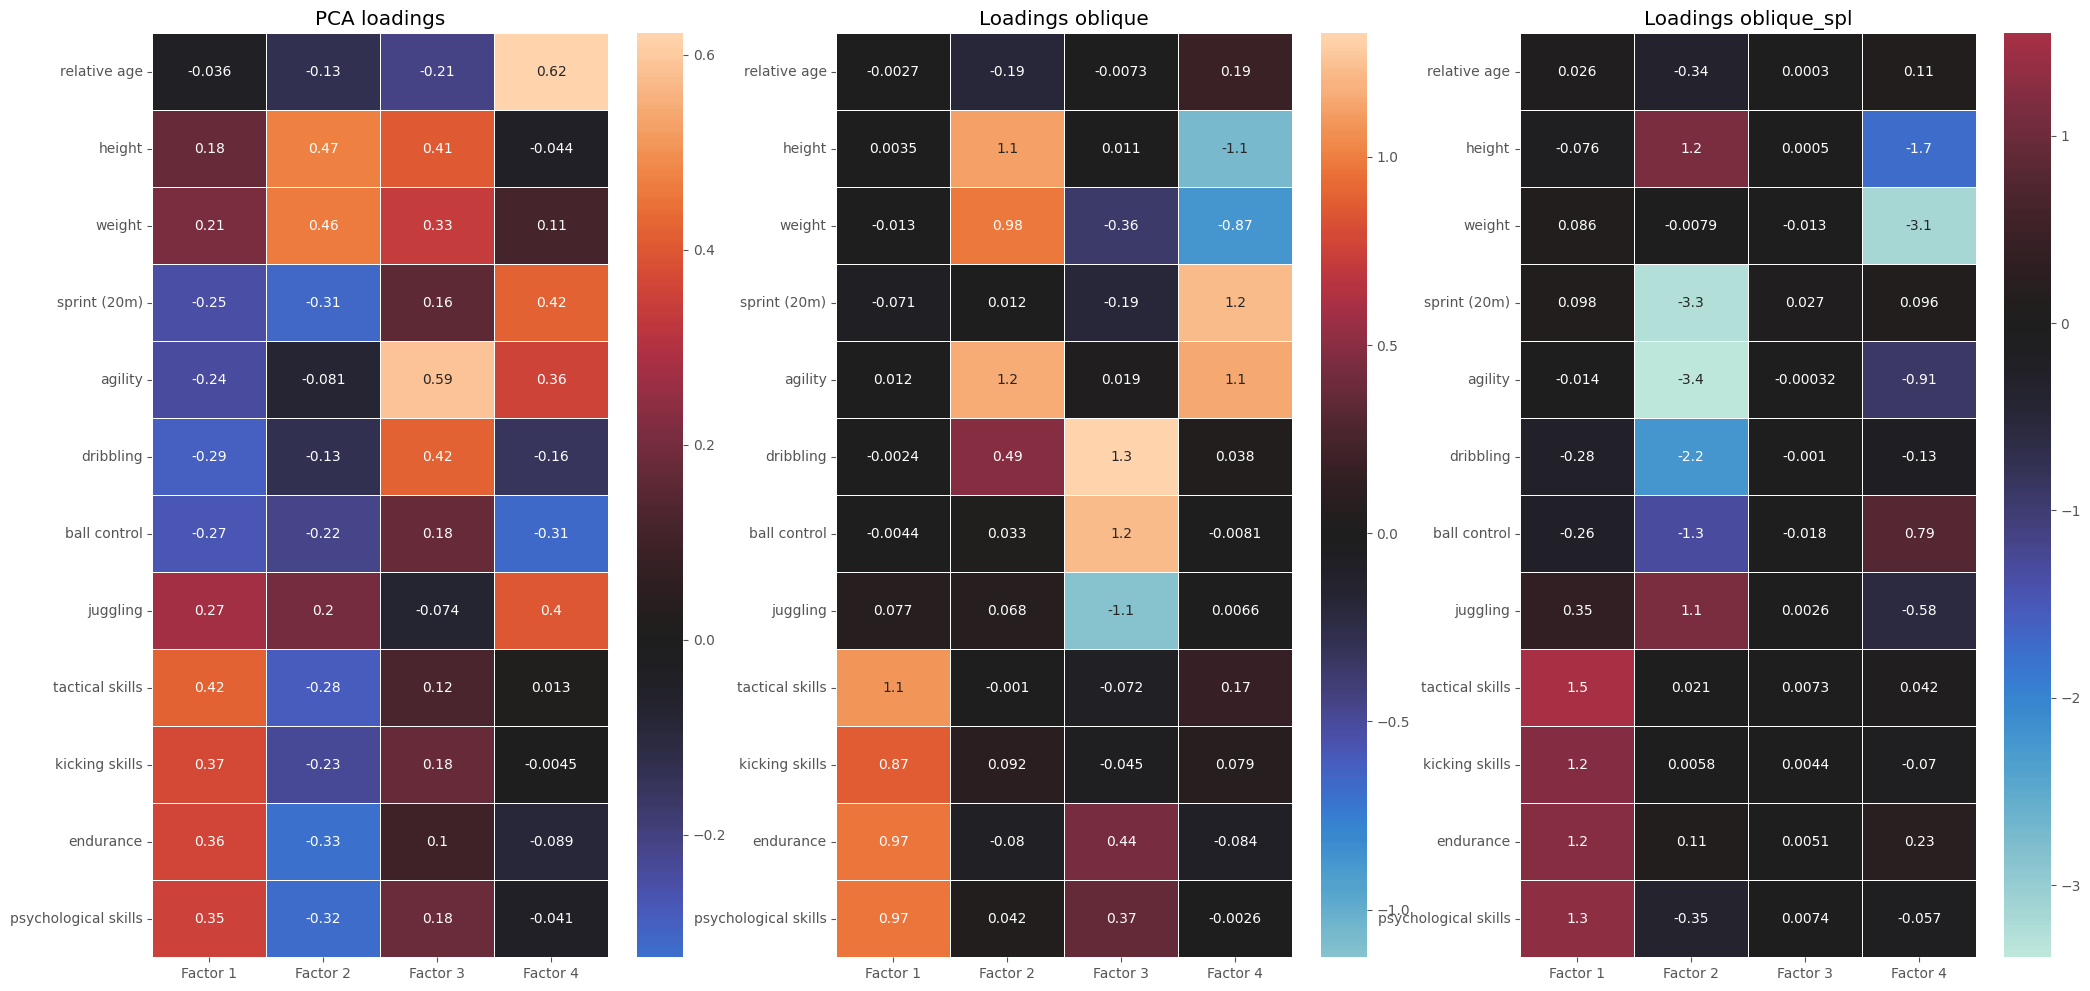

In [62]:
fig, axs = plt.subplots(1,3, figsize=(25,12))
sns.heatmap(ax=axs[0], data=loadings, annot=True, linewidths=0.5, vmin=loadings.min().min(), vmax=loadings.max().max(), center=0,xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='PCA loadings')
sns.heatmap(ax=axs[1], data=rot_loadings_iwave_fem[:,[3,0,2,1]], annot=True, linewidths=0.5, vmin=rot_loadings_iwave_fem.min(), vmax=rot_loadings_iwave_fem.max(), center=0, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='Loadings oblique')
sns.heatmap(ax=axs[2], data=rot_loadings_niwave_fem[:,[3,0,1,2,]], annot=True, linewidths=0.5, vmin=rot_loadings_niwave_fem.min(), vmax=rot_loadings_niwave_fem.max(), center=0, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names).set(title='Loadings oblique_spl')

[Text(0.5, 1.0, 'Nonlinear loadings')]

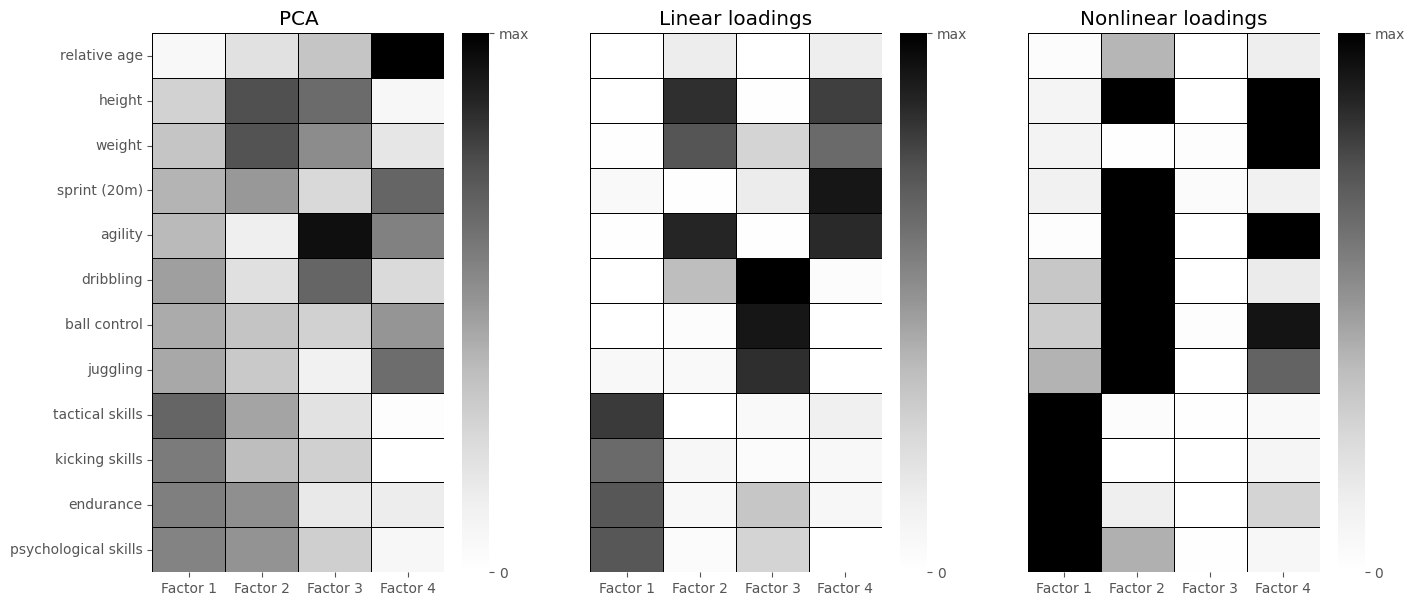

In [63]:
fig, axs = plt.subplots(1,3, figsize=(16,7), frameon=True)
sns.heatmap(ax=axs[0], data=abs(loadings), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=loadings.max().max()/2, vmax=loadings.max().max(),xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=X_names, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,loadings.max().max()],}).set(title='PCA')
sns.heatmap(ax=axs[1], data=abs(rot_loadings_iwave_fem[:,[3,0,2,1]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=rot_loadings_iwave_fem.max()/2, vmax=rot_loadings_iwave_fem.max(), xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar=True, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_iwave_fem.max()],}).set(title='Linear loadings')
sns.heatmap(ax=axs[2], data=abs(rot_loadings_niwave_fem[:,[3,0,1,2,]]), annot=False, linewidths=0.5, linecolor='black', vmin=0, center=(rot_loadings_niwave_fem.max()-0.7)/2,vmax=rot_loadings_niwave_fem.max()-0.7, xticklabels=["Factor 1", "Factor 2","Factor 3","Factor 4"], yticklabels=False, cmap = plt.cm.Greys, cbar_kws={'format': matplotlib.ticker.FixedFormatter(['0','max']),"ticks":[0,rot_loadings_niwave_fem.max()-0.7],}).set(title='Nonlinear loadings')

In [65]:
rot_load_table = torch.clone(rot_loadings_iwave_fem)
rot_load_table_spl = torch.clone(rot_loadings_niwave_fem)

loadings_table = loadings.copy()
loadings_table['variable'] = X_names
loadings_table.set_index('variable', inplace=True)
loadings_table.columns = ['fact. 1', 'fact. 2', 'fact. 3', 'fact. 4']

loadings_table[['iwave fact. 1', 'iwave fact. 2', 'iwave fact. 3', 'iwave fact. 4']] = rot_loadings_iwave_fem[:,[3,0,2,1]]
loadings_table[['niwave fact. 1', 'niwave fact. 2', 'niwave fact. 3', 'niwave fact. 4']] = rot_loadings_niwave_fem[:,[3,0,1,2,]]

loadings_table = round(loadings_table,2)
cut_percent = 0.1
pca_cut = cut_percent*loadings.max().max()
iwave_cut = np.asarray(cut_percent*rot_loadings_iwave_fem.max())
niwave_cut = np.asarray(cut_percent*(rot_loadings_niwave_fem.max()-0.7))
# pca
loadings_table.loc[np.abs(loadings_table['fact. 1']) < pca_cut, 'fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 2']) < pca_cut, 'fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 3']) < pca_cut, 'fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['fact. 4']) < pca_cut, 'fact. 4'] = '.'
# iwave
loadings_table.loc[np.abs(loadings_table['iwave fact. 1']) < iwave_cut, 'iwave fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 2']) < iwave_cut, 'iwave fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 3']) < iwave_cut, 'iwave fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['iwave fact. 4']) < iwave_cut, 'iwave fact. 4'] = '.'
# niwave
loadings_table.loc[np.abs(loadings_table['niwave fact. 1']) < niwave_cut, 'niwave fact. 1'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 2']) < niwave_cut, 'niwave fact. 2'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 3']) < niwave_cut, 'niwave fact. 3'] = '.'
loadings_table.loc[np.abs(loadings_table['niwave fact. 4']) < niwave_cut, 'niwave fact. 4'] = '.'


# print(round(loadings_table,2).to_latex(escape=True, index=True, index_names=False, column_format='lrrrrrrrrrrrr', ))
round(loadings_table,2)

C:\Users\eduar\AppData\Local\Temp\ipykernel_9644\1433928545.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  loadings_table.loc[np.abs(loadings_table['fact. 1']) < pca_cut, 'fact. 1'] = '.'
C:\Users\eduar\AppData\Local\Temp\ipykernel_9644\1433928545.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  loadings_table.loc[np.abs(loadings_table['fact. 2']) < pca_cut, 'fact. 2'] = '.'
C:\Users\eduar\AppData\Local\Temp\ipykernel_9644\1433928545.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast

,fact. 1,fact. 2,fact. 3,fact. 4,iwave fact. 1,iwave fact. 2,iwave fact. 3,iwave fact. 4,niwave fact. 1,niwave fact. 2,niwave fact. 3,niwave fact. 4
variable,,,,,,,,,,,,
relative age,.,-0.13,-0.21,0.62,.,-0.19,.,0.19,.,-0.34,.,0.11
height,0.18,0.47,0.41,.,.,1.12,.,-1.07,.,1.15,.,-1.73
weight,0.21,0.46,0.33,0.11,.,0.98,-0.36,-0.87,0.09,.,.,-3.14
sprint (20m),-0.25,-0.31,0.16,0.42,.,.,-0.19,1.23,0.1,-3.27,.,0.1
agility,-0.24,-0.08,0.59,0.36,.,1.16,.,1.15,.,-3.39,.,-0.91
dribbling,-0.29,-0.13,0.42,-0.16,.,0.49,1.33,.,-0.28,-2.22,.,-0.13
ball control,-0.27,-0.22,0.18,-0.31,.,.,1.23,.,-0.26,-1.29,.,0.79
juggling,0.27,0.2,-0.07,0.4,.,.,-1.13,.,0.35,1.13,.,-0.58
tactical skills,0.42,-0.28,0.12,.,1.08,.,.,0.17,1.55,.,.,.
